In [1]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import librosa
from IPython import display
import sys
sys.path.append("../")
from DSP_prototype.DSP_algorithms import stft, downsample_image_fixed, noise_reduction_gain_function
import tensorflow as tf
from tensorflow import keras
import tensorflow_model_optimization as tfmot
import os
import csv
import tempfile

2025-01-21 19:21:39.590646: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737483699.683032    6897 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737483699.712532    6897 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-21 19:21:39.922771: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
sample_rate = 16000
label_strings = ["down", "go", "left", "no", "off", "on", "right", "stop", "up", "yes", "silence", "unknown"]
selected_labels = [1, 2, 6, 7]
selected_labels_dict = {x:i for i, x in enumerate(selected_labels)}
NUM_CLASSES = len(selected_labels)
commands = [label_strings[x] for x in selected_labels]
selected_labels_str = [label_strings[x] for x in selected_labels]
prediction_dict = {i: label for i, label in enumerate(selected_labels_str)}
prediction_dict_reversed = {label: i for i, label in enumerate(selected_labels_str)}

In [3]:
dataset, info = tfds.load('speech_commands', with_info=True, as_supervised=True, split="test+validation+train")
print(f"Full dataset length: {len(dataset)}")

exclude_classes = [x for x in range(12) if x not in selected_labels]
dataset = dataset.shuffle(10000, seed=2137)

I0000 00:00:1737483702.690341    6897 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6137 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 Super, pci bus id: 0000:01:00.0, compute capability: 7.5


Full dataset length: 100503


In [4]:
def split_data_and_labels(dataset, length):
    data = []
    labels = []
    i = 0
    unknown_counter = 0
    for feature, label in dataset:
        print(i)
        if i == length:
            break
        
        pcm = feature.numpy()
        pcm_padded = np.pad(pcm, (0, sample_rate - len(pcm)), 'constant', constant_values=0)
        pcm_padded = pcm_padded.astype(np.float32)
        pcm_padded = librosa.resample(pcm_padded, orig_sr=16e3, target_sr=8e3)
        
        label = int(label.numpy())
        if label in selected_labels:
            if label == 11 and unknown_counter < 5:
                unknown_counter += 1
                
            if (label == 11 and unknown_counter == 5) or label != 11:

                
                pcm_padded = noise_reduction_gain_function(pcm_padded, 8000, 256, 128)
                data.append(pcm_padded)
                labels.append(selected_labels_dict.get(label))
                i += 1
                unknown_counter = 0
    return np.vstack(data), np.vstack(labels)


In [5]:
data, dataset_labels = split_data_and_labels(dataset, len(dataset))
NEW_DATASET_LENGTH = len(data)
print(f"Filtered length: {NEW_DATASET_LENGTH}")

2025-01-21 19:21:47.803697: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


0
0
0
1
1
1
1
2
3
3
4
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
8
8
9
9
9
10
11
11
12
13
14
14
15
15
15
15
16
16
16
16
16
17
17
17
17
17
17
17
18
19
19
19
19
19
19
19
19
19
19
19
20
20
20
20
20
20
20
20
20
20
20
20
20
20
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
22
22
22
22
22
22
22
22
22
22
22
22
22
22
23
23
23
23
23
23
23
24
25
25
25
25
26
26
26
26
26
27
27
27
27
27
27
27
27
27
28
29
29
29
30
30
30
31
31
31
32
32
32
32
32
32
33
33
34
34
34
34
35
35
35
35
35
35
35
35
35
35
35
35
36
36
36
36
36
36
36
36
36
37
37
38
39
39
39
40
41
41
41
41
41
42
42
42
43
43
43
43
43
43
44
44
44
45
45
46
46
46
46
46
46
46
46
46
46
46
46
46
47
47
48
48
48
48
48
48
48
48
48
48
48
48
49
49
49
49
49
49
50
50
50
50
50
50
50
50
50
50
50
50
50
50
51
51
51
51
51
51
51
51
51
51
51
51
51
51
52
52
52
52
52
52
52
52
53
53
53
53
53
54
54
54
54
54
54
54
54
54
55
55
55
55
55
55
55
56
56
56
56
56
56
56
56
56
56
57
57
58
58

2025-01-21 19:23:22.177568: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [71]:
TRAIN_PART = 0.7
VAL_PART = 0.1
TEST_PART = 0.2

train_data = data[:int(NEW_DATASET_LENGTH*TRAIN_PART)]
train_labels = dataset_labels[:int(NEW_DATASET_LENGTH*TRAIN_PART)]
TRAIN_LEN = len(train_data)

val_data = data[TRAIN_LEN:TRAIN_LEN+int(NEW_DATASET_LENGTH*VAL_PART)]
val_labels = dataset_labels[TRAIN_LEN:TRAIN_LEN+int(NEW_DATASET_LENGTH*VAL_PART)]
VAL_LEN = len(val_data)

test_data = data[TRAIN_LEN+VAL_LEN:]
test_labels = dataset_labels[TRAIN_LEN+VAL_LEN:]
TEST_LEN = len(test_data)

print(f"Train data length: {TRAIN_LEN}")
print(f"Validation data length: {VAL_LEN}")
print(f"Test data length: {TEST_LEN}")
print(f"Full dataset length: {NEW_DATASET_LENGTH}")

Train data length: 10731
Validation data length: 1533
Test data length: 3067
Full dataset length: 15331


In [38]:
print(f"[Train dataset] Max amplitude before normalization: {np.max(np.abs(train_data))}")
print(f"[Valid dataset] Max amplitude before normalization: {np.max(np.abs(val_data))}")
print(f"[Test dataset] Max amplitude before normalization: {np.max(np.abs(test_data))}")

train_data_max = np.max(np.abs(train_data))
valid_data_max = np.max(np.abs(val_data))
test_data_max = np.max(np.abs(test_data))

for i in range(len(train_data)):
    train_data[i] /= 32768.0
    print(i)

for i in range(len(val_data)):
    val_data[i] /= 32768.0
    print(i)

for i in range(len(test_data)):
    test_data[i] /= 32768.0
    print(i)

print(f"[Train dataset] Max amplitude after normalization: {np.max(np.abs(train_data))}")
print(f"[Valid dataset] Max amplitude after normalization: {np.max(np.abs(val_data))}")
print(f"[Test dataset] Max amplitude after normalization: {np.max(np.abs(test_data))}")

# train_data += np.random.normal(0, 0.01, train_data.shape)
# val_data += np.random.normal(0, 0.01, val_data.shape)
# test_data += np.random.normal(0, 0.01, test_data.shape)


[Train dataset] Max amplitude before normalization: 49288.7265625
[Valid dataset] Max amplitude before normalization: 1.4165685176849365
[Test dataset] Max amplitude before normalization: 52985.34765625
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226

# Spectrogram (old approach)

In [72]:
train_data = np.array([np.abs(stft(x, fs=8e3, N=256, hop_size=128)[0]) for x in train_data])
valid_data = np.array([np.abs(stft(x, fs=8e3, N=256, hop_size=128)[0]) for x in val_data])
test_data = np.array([np.abs(stft(x, fs=8e3, N=256, hop_size=128)[0]) for x in test_data])

In [58]:
train_data.shape

(10731, 32, 61)

In [73]:
train_data = np.array([downsample_image_fixed(x.reshape(129*61), 129, 61, 32, 32) for x in train_data])
valid_data = np.array([downsample_image_fixed(x.reshape(129*61), 129, 61, 32, 32) for x in valid_data])
test_data = np.array([downsample_image_fixed(x.reshape(129*61), 129, 61, 32, 32) for x in test_data])

In [16]:
train_data.shape

(10731, 32, 32)

In [74]:
train_data = train_data.reshape(len(train_data), train_data[0].shape[0], train_data[0].shape[1], 1)
valid_data = valid_data.reshape(len(valid_data), valid_data[0].shape[0], valid_data[0].shape[1], 1)
test_data = test_data.reshape(len(test_data), test_data[0].shape[0], test_data[0].shape[1], 1)

In [76]:
train_data = np.array([tf.image.resize(x, (32, 32)) for x in train_data])
valid_data = np.array([tf.image.resize(x, (32, 32)) for x in valid_data])
test_data = np.array([tf.image.resize(x, (32, 32)) for x in test_data])

In [77]:
train_data.shape

(21091, 32, 32, 1)

# Traing normal model

In [173]:
input_shape = train_data[0].shape 
print('Input shape:', input_shape)



# model = keras.Sequential([
#     keras.layers.Input(shape=input_shape),
#     keras.layers.Conv2D(16, 3, activation='relu', padding="same"),
#     keras.layers.Conv2D(32, 3, activation='relu', padding="same"),
#     keras.layers.MaxPooling2D((2, 2)),
#     keras.layers.Dropout(0.3),
#     keras.layers.Conv2D(32, 3, activation='relu', padding="same"),
#     keras.layers.Conv2D(64, 3, activation='relu', padding="same"),
#     keras.layers.Flatten(),
#     keras.layers.Dropout(0.1),
#     keras.layers.Dense(32, activation='relu'),
#     keras.layers.Dense(512, activation='relu'),
#     keras.layers.Dropout(0.4),
#     keras.layers.Dense(NUM_CLASSES, activation='softmax'),
# ])

model = keras.Sequential([
    keras.layers.Input(shape=input_shape),
    keras.layers.Conv2D(16, 3, activation='relu'),
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.Conv2D(48, 3, activation='relu'),
    keras.layers.Conv2D(64, 3, activation='relu'),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(NUM_CLASSES, activation='softmax'),
])





# input_shape = train_data[0].shape  # This will now be (129, 126, 1)
# print('Input shape:', input_shape)
# 
# # Instantiate the `tf.keras.layers.Normalization` layer.
# norm_layer = keras.layers.Normalization()
# # Fit the state of the layer to the spectrograms
# # with `Normalization.adapt`.
# norm_layer.adapt(train_data)
# 
# model = keras.models.Sequential([
#     keras.layers.Input(shape=input_shape),
#     # Downsample the input.
#     keras.layers.Resizing(32, 32),
#     # Normalize.
#     norm_layer,
#     keras.layers.Conv2D(16, 3, activation='relu'),
#     keras.layers.Conv2D(32, 3, activation='relu'),
#     keras.layers.MaxPooling2D((2,2)),
#     keras.layers.Dropout(0.3),
#     keras.layers.Conv2D(32, 3, activation='relu'),
#     keras.layers.Conv2D(64, 3, activation='relu'),
#     keras.layers.GlobalAveragePooling2D(),
#     keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dropout(0.2),
#     keras.layers.Dense(NUM_CLASSES, activation='softmax'),
# ])

model.summary()

Input shape: (32, 32, 1)
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_129 (Conv2D)         (None, 30, 30, 16)        160       
                                                                 
 conv2d_130 (Conv2D)         (None, 28, 28, 32)        4640      
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_61 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 conv2d_131 (Conv2D)         (None, 12, 12, 32)        9248      
                                                                 
 conv2d_132 (Conv2D)         (None, 10, 10, 48)        13872     
                            

In [174]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(verbose=1, patience=10)
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

train_labels = np.array(train_labels, dtype=np.float32)
valid_labels = np.array(val_labels, dtype=np.float32)


EPOCHS = 100
history = model.fit(train_data, train_labels,
    validation_data=(valid_data, valid_labels),
    epochs=EPOCHS,
    callbacks=callbacks,
    batch_size=1024,
)

Epoch 1/100


E0000 00:00:1737488268.713276    6897 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_25/dropout_61/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


11/11 [==============================] - 3s 57ms/step - loss: 53.7354 - accuracy: 0.2726 - val_loss: 2.2771 - val_accuracy: 0.3496
Epoch 2/100
11/11 [==============================] - 0s 39ms/step - loss: 3.0140 - accuracy: 0.3273 - val_loss: 1.3622 - val_accuracy: 0.3927
Epoch 3/100
11/11 [==============================] - 0s 40ms/step - loss: 1.6855 - accuracy: 0.3249 - val_loss: 1.3087 - val_accuracy: 0.4038
Epoch 4/100
11/11 [==============================] - 0s 42ms/step - loss: 1.4423 - accuracy: 0.3393 - val_loss: 1.3056 - val_accuracy: 0.3947
Epoch 5/100
11/11 [==============================] - 0s 42ms/step - loss: 1.3995 - accuracy: 0.3359 - val_loss: 1.2975 - val_accuracy: 0.4110
Epoch 6/100
11/11 [==============================] - 0s 40ms/step - loss: 1.3679 - accuracy: 0.3561 - val_loss: 1.2825 - val_accuracy: 0.4279
Epoch 7/100
11/11 [==============================] - 0s 37ms/step - loss: 1.3444 - accuracy: 0.3740 - val_loss: 1.2647 - val_accuracy: 0.4436
Epoch 8/100
11/11

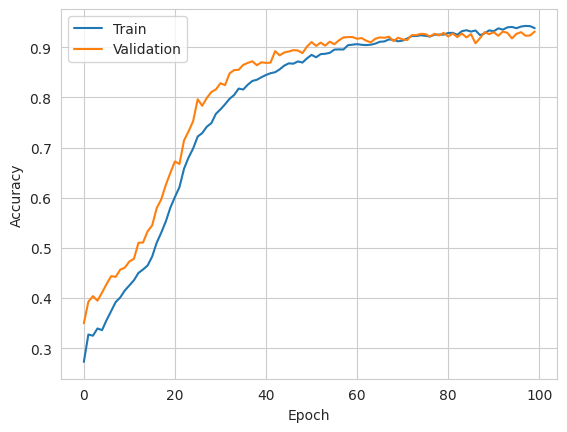

In [193]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["Train", "Validation"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

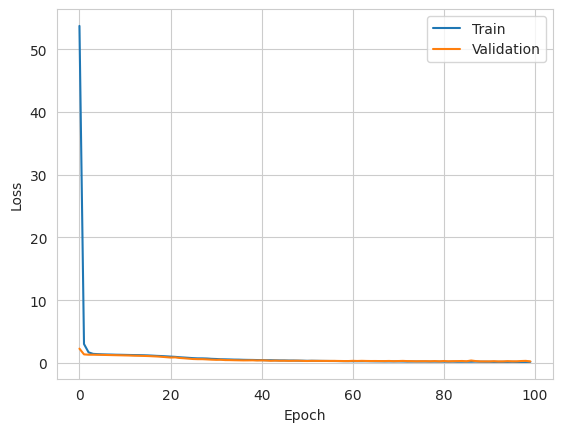

In [194]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["Train", "Validation"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [195]:
model =  keras.models.load_model("to_be_deployed/tra_61percent_deployed_base.h5")

In [196]:
model.evaluate(test_data, test_labels)

96/96 [==============================] - 0s 2ms/step - loss: 5122.3882 - accuracy: 0.8957


[5122.38818359375, 0.8956634998321533]

In [179]:
model.save("tra_getting_REALLY_close_66percent_on_dataset.h5")

/home/vistek528/anaconda3/envs/DeepLearning/lib/python3.9/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
directory_path = "../Data_acquisition/data/audio/8kHz_augmented"
file_list = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]

samples = []
labels = []

for file_name in file_list:
    with open(os.path.join(directory_path, file_name), 'r') as file:
        file_data = []
        reader = csv.DictReader(file)
        for row in reader:
            file_data.append(float(row['y']))  # Convert to int if y is numeric
            
        label_str = file_name.split("_")[0]
        if len(file_data) == 8e3:
            class_from_dict = prediction_dict_reversed.get(label_str)
            if class_from_dict is not None:
                labels.append(prediction_dict_reversed.get(label_str))
                #samples.append(nr.reduce_noise(y=file_data, y_noise=noise, sr=8000))
                samples.append(noise_reduction_gain_function(file_data, 8000, 256, 128))
                

microphone_data = np.array([np.abs(stft(x, fs=8e3, N=256, hop_size=128)[0]) for x in samples]).astype(np.float32)
microphone_data_resized = microphone_data.reshape(len(microphone_data), microphone_data.shape[1], microphone_data.shape[2], 1)
microphone_data_resized = tf.image.resize(microphone_data_resized, [32, 32])

# microphone_data = np.array([librosa.feature.mfcc(y=x, sr=8000, n_mfcc=16) for x in samples]).astype(np.float32)
# microphone_data_resized = microphone_data.reshape(len(microphone_data), microphone_data.shape[1], microphone_data.shape[2], 1)


microphone_labels = np.array(labels, dtype=np.int64)

In [199]:
microphone_data_resized.shape

TensorShape([1980, 32, 32, 1])

In [188]:
model =  keras.models.load_model("to_be_deployed/tra_61percent_deployed_base.h5")

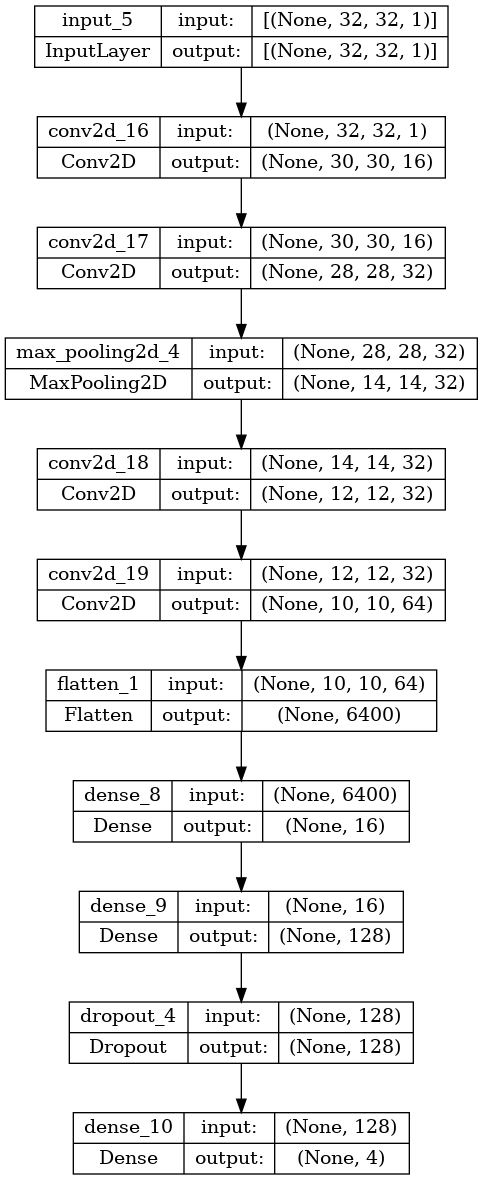

In [212]:
keras.utils.plot_model(model, show_shapes=True)

In [192]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 30, 30, 16)        160       
                                                                 
 conv2d_17 (Conv2D)          (None, 28, 28, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 12, 12, 32)        9248      
                                                                 
 conv2d_19 (Conv2D)          (None, 10, 10, 64)        18496     
                                                                 
 flatten_1 (Flatten)         (None, 6400)              0         
                                                      

In [208]:
y_pred_model = model.predict(microphone_data_resized)

62/62 [==============================] - 0s 1ms/step


In [29]:
import seaborn as sns

In [198]:
model.evaluate(microphone_data_resized, tf.expand_dims(microphone_labels, 1))

62/62 [==============================] - 0s 2ms/step - loss: 1826.6559 - accuracy: 0.6475


[1826.6558837890625, 0.6474747657775879]

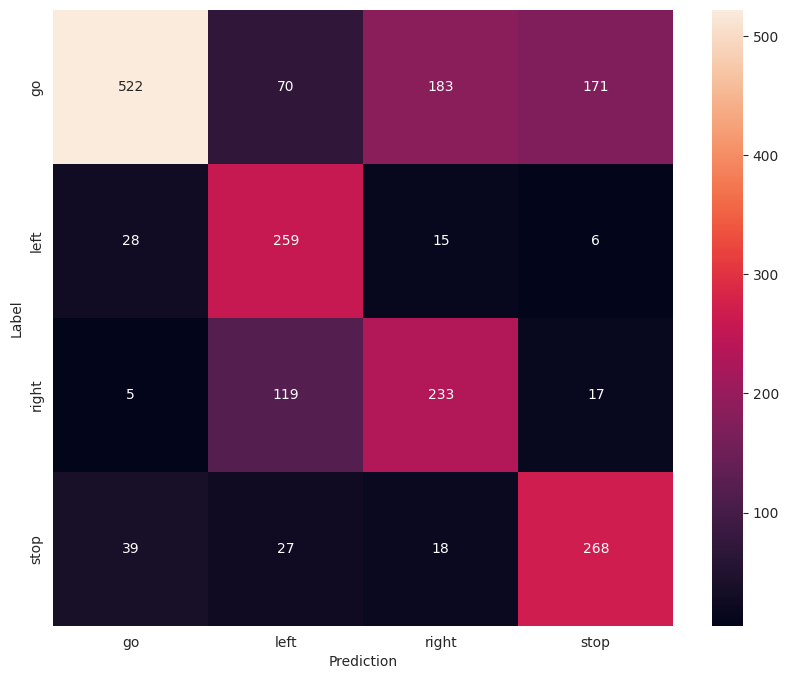

In [209]:

confusion_mtx = tf.math.confusion_matrix(microphone_labels, np.argmax(y_pred_model, axis=1))
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [210]:
confusion_mtx

<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[522,  70, 183, 171],
       [ 28, 259,  15,   6],
       [  5, 119, 233,  17],
       [ 39,  27,  18, 268]], dtype=int32)>

In [34]:
directory_path = "../Data_acquisition/data/audio/8kHz_sampling"
file_list = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]

samples = []
labels = []

for file_name in file_list:
    with open(os.path.join(directory_path, file_name), 'r') as file:
        file_data = []
        reader = csv.DictReader(file)
        for row in reader:
            file_data.append(float(row['y']))  # Convert to int if y is numeric

        label_str = file_name.split("_")[0]
        if len(file_data) == 8e3:
            class_from_dict = prediction_dict_reversed.get(label_str)
            if class_from_dict is not None:
                labels.append(prediction_dict_reversed.get(label_str))
                #samples.append(file_data)
                samples.append(noise_reduction_gain_function(file_data, 8000, 256, 128))
                


microphone_data_dataset_spectrograms = np.array([np.abs(stft(x, fs=8e3, N=256, hop_size=128)[0]) for x in samples]).astype(np.float32)
microphone_data_dataset = np.array([downsample_image_fixed(x.reshape(129*61), 129, 61, 32, 32) for x in microphone_data_dataset_spectrograms])
microphone_data_dataset_resized = microphone_data_dataset.reshape(len(microphone_data_dataset), microphone_data_dataset.shape[1], microphone_data_dataset.shape[2], 1)

# microphone_data = np.array([librosa.feature.mfcc(y=x, sr=8000, n_mfcc=16) for x in samples]).astype(np.float32)
# microphone_data_resized = microphone_data.reshape(len(microphone_data), microphone_data.shape[1], microphone_data.shape[2], 1)


microphone_labels_dataset = np.array(labels, dtype=np.int64)

In [35]:
model.evaluate(microphone_data_dataset_resized, tf.expand_dims(microphone_labels_dataset, 1))

3/3 [==============================] - 0s 42ms/step - loss: 0.7167 - accuracy: 0.7386


[0.7166957855224609, 0.7386363744735718]

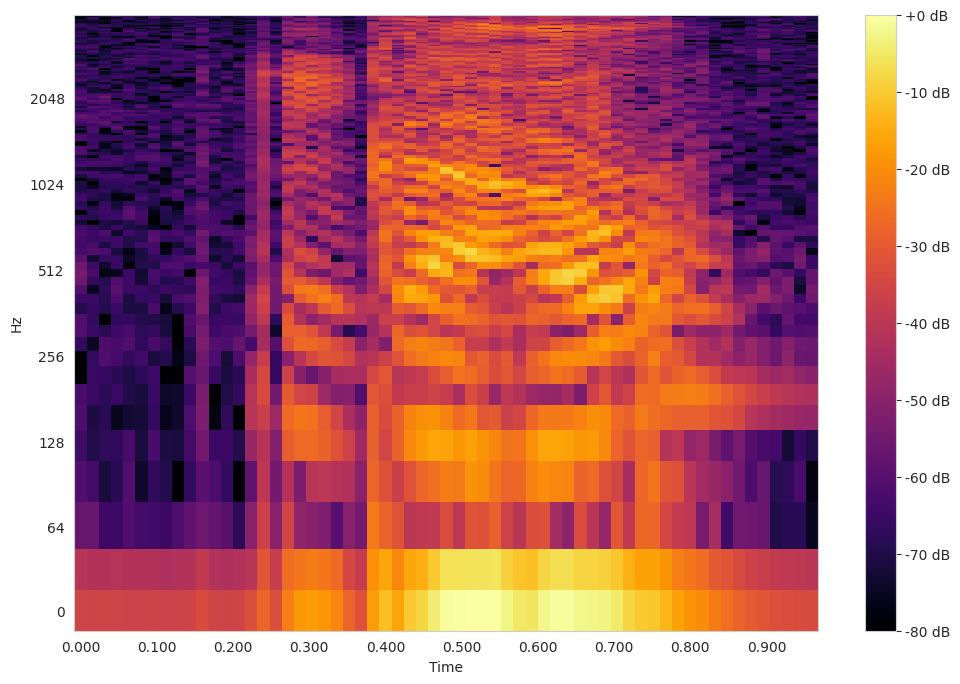

In [124]:
S_db = librosa.amplitude_to_db(microphone_data_dataset_spectrograms[5], ref = np.max)
# Plot the spectrogram
plt.figure(figsize=(12, 8))
librosa.display.specshow(S_db, x_axis='time', y_axis='log', sr=8e3, cmap='inferno',
                         hop_length=128)
plt.colorbar(format='%+2.0f dB')
plt.show()

In [202]:
def representative_dataset_gen():
    for input_value in microphone_data_resized:
        yield [tf.expand_dims(input_value, 0)]


# Wrap the conversion in a custom_object_scope
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.float32  
converter.inference_output_type = tf.float32  
tflite_model = converter.convert()


with open('tra_getting_really_close.tflite', 'wb') as f:
    f.write(tflite_model)

model_Size = os.path.getsize("tra_getting_really_close.tflite")
print(f"Model ma {model_Size / 1e3} kB")

INFO:tensorflow:Assets written to: /tmp/tmp387_a__d/assets


INFO:tensorflow:Assets written to: /tmp/tmp387_a__d/assets
/home/vistek528/anaconda3/envs/DeepLearning/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1737495921.349134    6897 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1737495921.349157    6897 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-01-21 22:45:21.349340: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp387_a__d
2025-01-21 22:45:21.351306: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-01-21 22:45:21.351322: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp387_a__d
2025-01-21 22:45:21.364824: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-01-21 22:45:21.432413: I tensorflow/cc/saved_model/l

Model ma 150.888 kB


fully_quantize: 0, inference_type: 6, input_inference_type: FLOAT32, output_inference_type: FLOAT32


In [36]:
valid_data.shape

(1533, 32, 32, 1)

In [37]:
microphone_data_dataset_resized.shape

(51, 32, 32, 1)

In [62]:
selected_labels_str

['go', 'left', 'right', 'stop', 'silence', 'unknown']

In [204]:
interpreter = tf.lite.Interpreter(model_path="to_be_deployed/tra_61percent_deployed.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Data Type:", input_details[0]['dtype'])

Input Shape: [ 1 32 32  1]
Input Data Type: <class 'numpy.float32'>


In [205]:
y_pred = []
y_pred_probabilities = []
correctly = 0

for sample, y_true in zip(microphone_data_resized, microphone_labels):

    # Przekazanie danych do interpretera
    interpreter.set_tensor(input_details[0]['index'], tf.expand_dims(sample, 0))
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])[0]

    
    # Klasyfikacja (argmax)
    predicted_class = np.argmax(output_data)
    y_pred_probabilities.append(output_data)  # Możesz zapisać odkwantyzowane wyjście dla analizy
    
    # Sprawdzenie poprawności klasyfikacji
    if predicted_class == y_true:
        correctly += 1
    y_pred.append(predicted_class)
    
    print(f"Y_pred={predicted_class} | Y_true={y_true}")


Y_pred=0 | Y_true=0
Y_pred=0 | Y_true=3
Y_pred=0 | Y_true=0
Y_pred=3 | Y_true=3
Y_pred=3 | Y_true=3
Y_pred=0 | Y_true=0
Y_pred=0 | Y_true=0
Y_pred=0 | Y_true=0
Y_pred=1 | Y_true=1
Y_pred=2 | Y_true=0
Y_pred=3 | Y_true=3
Y_pred=0 | Y_true=3
Y_pred=0 | Y_true=0
Y_pred=1 | Y_true=2
Y_pred=1 | Y_true=2
Y_pred=0 | Y_true=0
Y_pred=0 | Y_true=0
Y_pred=0 | Y_true=0
Y_pred=1 | Y_true=1
Y_pred=0 | Y_true=0
Y_pred=3 | Y_true=3
Y_pred=0 | Y_true=0
Y_pred=1 | Y_true=1
Y_pred=0 | Y_true=0
Y_pred=1 | Y_true=2
Y_pred=2 | Y_true=3
Y_pred=0 | Y_true=0
Y_pred=2 | Y_true=2
Y_pred=0 | Y_true=0
Y_pred=1 | Y_true=2
Y_pred=1 | Y_true=1
Y_pred=0 | Y_true=0
Y_pred=1 | Y_true=1
Y_pred=2 | Y_true=0
Y_pred=3 | Y_true=3
Y_pred=0 | Y_true=0
Y_pred=2 | Y_true=2
Y_pred=0 | Y_true=0
Y_pred=0 | Y_true=0
Y_pred=3 | Y_true=0
Y_pred=0 | Y_true=0
Y_pred=3 | Y_true=1
Y_pred=1 | Y_true=1
Y_pred=0 | Y_true=0
Y_pred=3 | Y_true=3
Y_pred=1 | Y_true=1
Y_pred=0 | Y_true=0
Y_pred=0 | Y_true=0
Y_pred=0 | Y_true=0
Y_pred=1 | Y_true=1


In [206]:
print(f"Accuracy: {(correctly/len(microphone_labels))*100:.2f}%")

Accuracy: 64.85%


In [338]:
print(f"Accuracy: {(correctly2/len(microphone_labels))*100:.2f}%")

Accuracy: 37.91%


In [154]:
labels

array([[4],
       [1],
       [1],
       ...,
       [0],
       [2],
       [3]])

In [123]:
import seaborn as sns

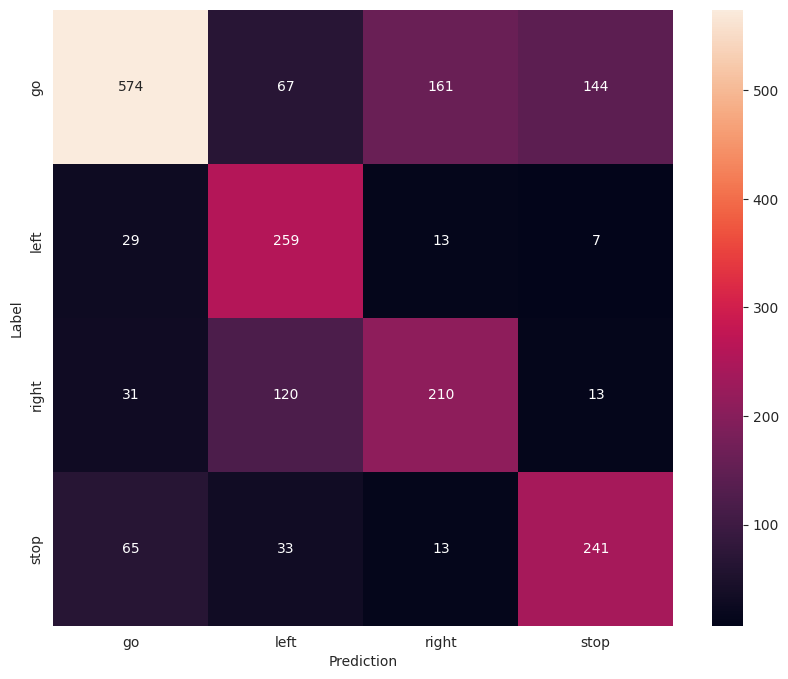

In [207]:

confusion_mtx = tf.math.confusion_matrix(microphone_labels, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [499]:
S, _, _ = stft(noise, fs=8000, N=256, hop_size=128)

In [502]:
np.abs(S)

array([[435.99113731, 482.37663555, 480.05789027, ..., 463.14276911,
        480.61503087, 432.05278079],
       [208.81383555, 238.35012289, 251.29561891, ..., 241.85701207,
        254.94971011, 204.59306768],
       [ 20.29911283,   1.89553186,  13.1480823 , ...,  17.72234188,
         37.32021157,  14.33772994],
       ...,
       [  5.03355162,  16.16285043,  28.68250135, ...,  10.21588269,
          6.78246755,   3.85476972],
       [ 11.76981259,  13.28726097,  25.80400156, ...,   7.47750887,
         22.67437402,  11.96070071],
       [  2.16472139,   1.06444376,  21.16600767, ...,   8.61588059,
         30.62261863,   3.08399227]])

In [368]:
audio_file = "../Data_acquisition/data/audio/8kHz_sampling/go_fs=8kHz_31.csv"
stft_file = "../Data_acquisition/data/stft/8kHz_sampling/stft_go_fs=8kHz_31.csv"

In [369]:
import noisereduce as nr

In [370]:
audio_data = []
with open(audio_file, 'r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        audio_data.append(float(row['y']))  # Convert to int if y is numeric

audio_data = np.array(audio_data, dtype=np.float32)
print(f"Data length before resampling: {len(audio_data)}")
print(f"Data type before resampling: {type(audio_data[0])}")
audio_data_nr= nr.reduce_noise(y=audio_data, y_noise=noise, sr=8000)

Data length before resampling: 7999
Data type before resampling: <class 'numpy.float32'>


# Custom noise reduction

In [345]:
microphone_data_sample = stft(audio_data, fs=8e3, N=256, hop_size=128)[0]

In [293]:
microphone_data_sample.shape

(129, 61)

In [271]:
from scipy.signal import istft

In [272]:
noise_est = np.mean(np.abs(microphone_data_sample[:, :2])**2, axis=1)
Sxx = np.abs(microphone_data_sample)**2 - noise_est[:, None]
Sxx = np.maximum(Sxx, 0)  # Avoid negative values
Zxx_clean = np.sqrt(Sxx) * np.exp(1j * np.angle(microphone_data_sample)) 
audio_clean = librosa.istft(Zxx_clean, hop_length=128, n_fft=256)

In [246]:
from scipy.signal import stft as scipy_stft

In [378]:
S = librosa.stft(audio_data, n_fft=256, hop_length=128)

In [382]:
S_abs = np.abs(S)

In [386]:
S_abs[:, :10]

array([[ 473.91196 ,  899.1813  ,  866.77454 , ..., 1142.2115  ,
        1629.1589  , 2329.3386  ],
       [ 384.7331  ,  451.35788 ,  438.54913 , ...,  540.6541  ,
         783.0763  , 1219.108   ],
       [ 202.71384 ,   34.307343,   16.84524 , ...,   66.06746 ,
         133.27248 ,   76.51136 ],
       ...,
       [  21.65745 ,   33.847733,   30.588362, ...,   24.479776,
          31.857435,   35.351635],
       [  18.245064,   25.587185,   15.54754 , ...,   16.766638,
          27.673615,   48.642063],
       [   9.084911,   58.04606 ,   25.097433, ...,   18.731207,
           8.673501,   15.083442]], dtype=float32)

In [385]:
np.mean(S_abs[:, :10], axis=1)

array([1113.3849  ,  567.6542  ,   67.41083 ,   66.841194,  119.94234 ,
        204.52878 ,  105.86693 ,  114.01228 ,   98.440186,   98.02355 ,
        108.74099 ,   66.29126 ,  149.56284 ,  185.34538 ,  203.19412 ,
        154.18037 ,   47.268623,   73.15674 ,   65.802315,   58.75172 ,
         49.912872,   56.01665 ,   50.14902 ,   61.29389 ,   50.086403,
         34.795666,   58.091026,   65.68495 ,   53.02064 ,   46.776714,
         41.892136,   50.588676,   46.031166,   51.105602,   47.89986 ,
         72.05478 ,   65.27138 ,   74.52754 ,   93.79023 ,   69.15127 ,
         83.44162 ,   71.602135,   45.454548,   52.830524,   57.6498  ,
         57.541023,   58.654976,   54.347473,   50.789013,   69.0616  ,
         59.38452 ,   57.14765 ,   47.900406,   48.672554,   61.34604 ,
         65.07231 ,   63.361217,   61.630024,   61.682487,   43.965553,
         60.920116,   61.918663,   70.863754,   65.34028 ,   80.2325  ,
         68.8525  ,   72.15765 ,   94.70803 ,  100.8678  ,   71.

In [380]:
np.max(S)

(23938.072+0j)

In [371]:
clean_signal = noise_reduction_gain_function(audio_data, 8000, frame_size=256, overlap=128)

187.01619
phase (129, 64)
[[9.01355133e+01]
 [2.31948910e+01]
 [4.63496983e-01]
 [3.80444050e-01]
 [2.49291134e+00]
 [7.23279667e+00]
 [1.61525178e+00]
 [1.70572984e+00]
 [1.42917693e+00]
 [2.42430711e+00]
 [2.48876715e+00]
 [3.85319620e-01]
 [3.94609833e+00]
 [7.16691303e+00]
 [1.05409861e+01]
 [5.50783634e+00]
 [1.97093099e-01]
 [8.67765129e-01]
 [4.55542475e-01]
 [3.26248467e-01]
 [2.23332167e-01]
 [3.30607086e-01]
 [3.13735425e-01]
 [4.01439995e-01]
 [2.43272021e-01]
 [8.47018734e-02]
 [3.43009382e-01]
 [6.24395490e-01]
 [4.01336104e-01]
 [2.44656414e-01]
 [1.25455946e-01]
 [2.35229179e-01]
 [1.71445444e-01]
 [2.20230415e-01]
 [1.79614916e-01]
 [3.71331483e-01]
 [3.19657505e-01]
 [4.04832125e-01]
 [6.37685478e-01]
 [3.65848392e-01]
 [6.30514145e-01]
 [4.40303415e-01]
 [1.52658612e-01]
 [2.01131135e-01]
 [2.32493639e-01]
 [2.38507941e-01]
 [2.56208897e-01]
 [2.26099104e-01]
 [1.89387515e-01]
 [3.62683743e-01]
 [2.59926498e-01]
 [2.40186840e-01]
 [1.67239428e-01]
 [1.76519275e-01]
 [

In [372]:
clean_signal.dtype

dtype('float32')

In [373]:
display.Audio(audio_data, rate=8000)

In [374]:
display.Audio(clean_signal, rate=8000)

In [377]:
np.hanning(256)/sum(np.hanning(256))

array([0.00000000e+00, 1.19038440e-06, 4.76081492e-06, 1.07091240e-05,
       1.90317004e-05, 2.97234915e-05, 4.27780064e-05, 5.81873197e-05,
       7.59420766e-05, 9.60314981e-05, 1.18443388e-04, 1.43164140e-04,
       1.70178747e-04, 1.99470808e-04, 2.31022539e-04, 2.64814787e-04,
       3.00827035e-04, 3.39037421e-04, 3.79422748e-04, 4.21958497e-04,
       4.66618846e-04, 5.13376681e-04, 5.62203616e-04, 6.13070008e-04,
       6.65944977e-04, 7.20796422e-04, 7.77591043e-04, 8.36294361e-04,
       8.96870736e-04, 9.59283393e-04, 1.02349444e-03, 1.08946490e-03,
       1.15715472e-03, 1.22652280e-03, 1.29752703e-03, 1.37012431e-03,
       1.44427056e-03, 1.51992077e-03, 1.59702901e-03, 1.67554847e-03,
       1.75543148e-03, 1.83662954e-03, 1.91909336e-03, 2.00277287e-03,
       2.08761728e-03, 2.17357508e-03, 2.26059407e-03, 2.34862143e-03,
       2.43760373e-03, 2.52748693e-03, 2.61821647e-03, 2.70973728e-03,
       2.80199378e-03, 2.89492997e-03, 2.98848943e-03, 3.08261536e-03,
      

In [207]:
noise.shape

(129, 5)

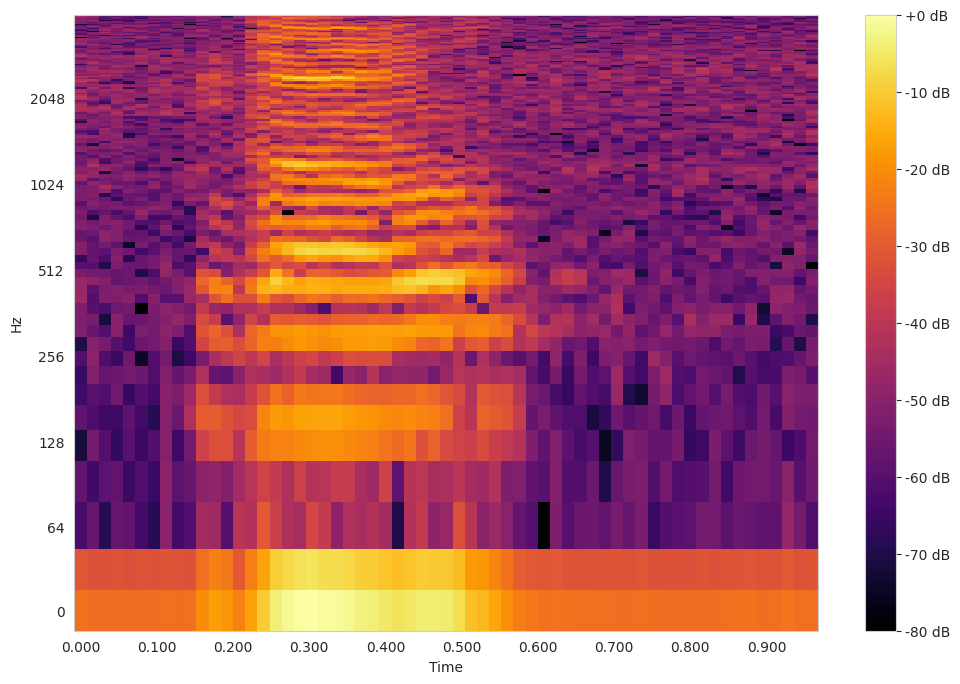

In [362]:
S_db = librosa.amplitude_to_db(np.abs(stft(audio_data, fs=8000, N=256, hop_size=128)[0]), ref = np.max)
# Plot the spectrogram
plt.figure(figsize=(12, 8))
librosa.display.specshow(S_db, x_axis='time', y_axis='log', sr=8e3, cmap='inferno',
                         hop_length=128)
plt.colorbar(format='%+2.0f dB')
plt.show()

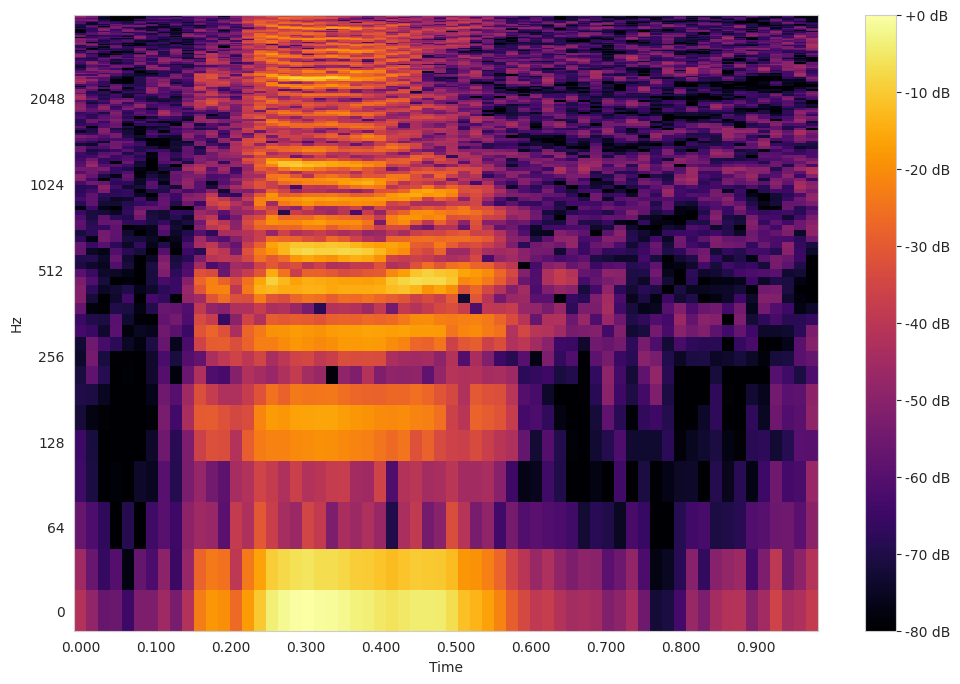

In [363]:
S_db = librosa.amplitude_to_db(np.abs(stft(clean_signal, fs=8000, N=256, hop_size=128)[0]), ref = np.max)
# Plot the spectrogram
plt.figure(figsize=(12, 8))
librosa.display.specshow(S_db, x_axis='time', y_axis='log', sr=8e3, cmap='inferno',
                         hop_length=128)
plt.colorbar(format='%+2.0f dB')
plt.show()

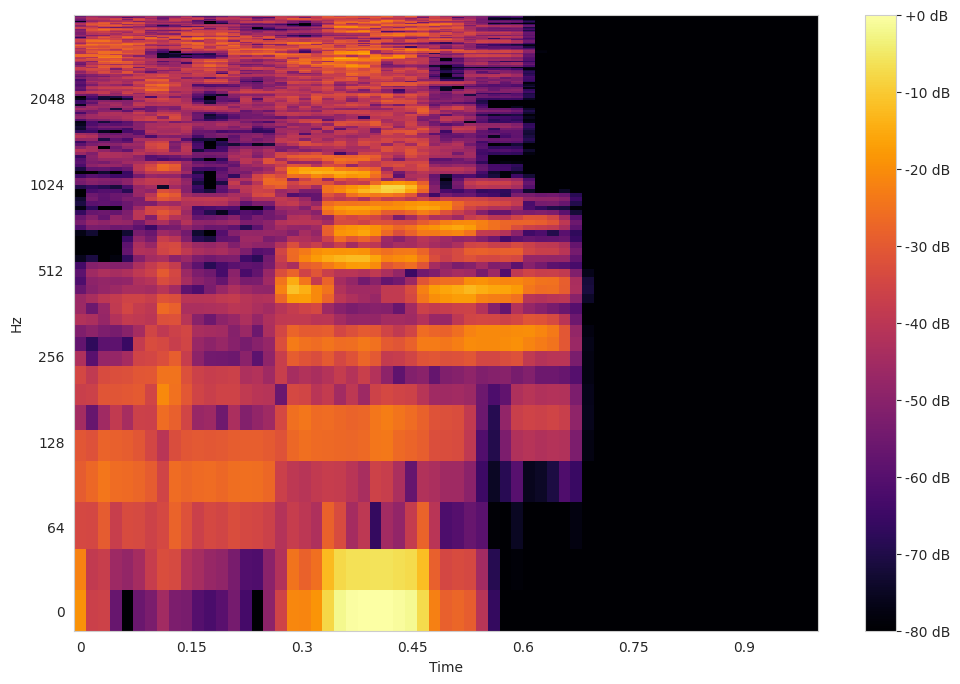

In [303]:
S_db = librosa.amplitude_to_db(np.abs(stft(clean_signal, fs=8000, N=256, hop_size=128)[0]), ref = np.max)
# Plot the spectrogram
plt.figure(figsize=(12, 8))
librosa.display.specshow(S_db, x_axis='time', y_axis='log', sr=8e3, cmap='inferno',
                         hop_length=128)
plt.colorbar(format='%+2.0f dB')
plt.show()

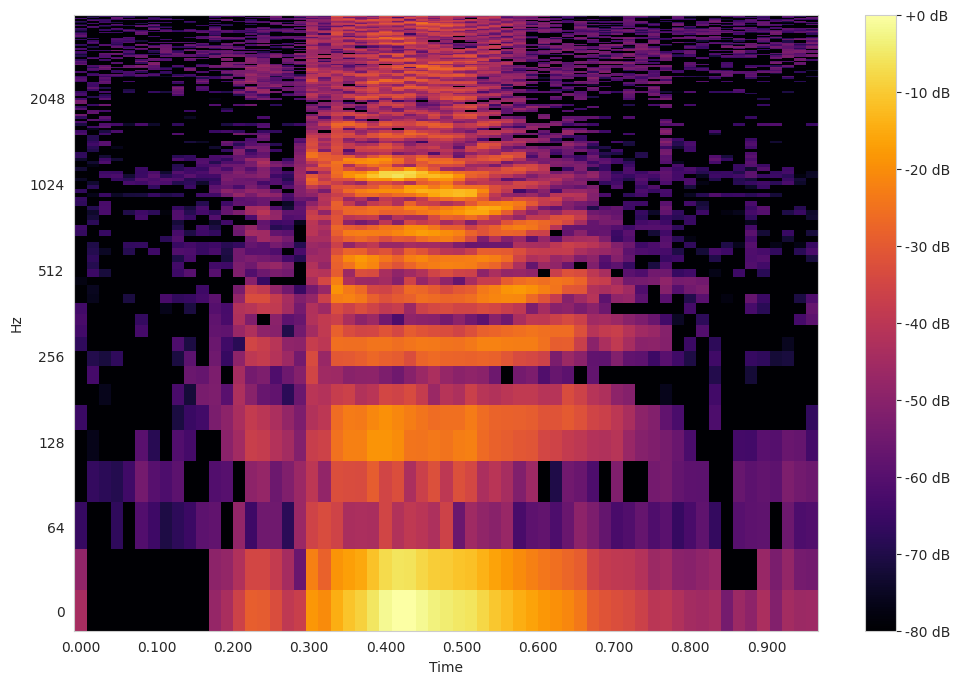

In [245]:
S_db = librosa.amplitude_to_db(np.abs(Zxx_clean ), ref = np.max)
# Plot the spectrogram
plt.figure(figsize=(12, 8))
librosa.display.specshow(S_db, x_axis='time', y_axis='log', sr=8e3, cmap='inferno',
                         hop_length=128)
plt.colorbar(format='%+2.0f dB')
plt.show()

In [111]:
display.Audio(audio_data, rate=8000)

In [125]:
display.Audio(audio_data_nr, rate=8000)

In [114]:
stft_data = []
with open(stft_file, 'r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        stft_data.append(float(row['stft_value']))  # Convert to int if y is numeric

stft_data = np.array(stft_data, dtype=np.float32)
print(f"stft_data shape: {stft_data.shape}")

stft_data shape: (7869,)


In [115]:
microphone_data_sample = np.abs(stft(audio_data, fs=8e3, N=256, hop_size=128)[0])

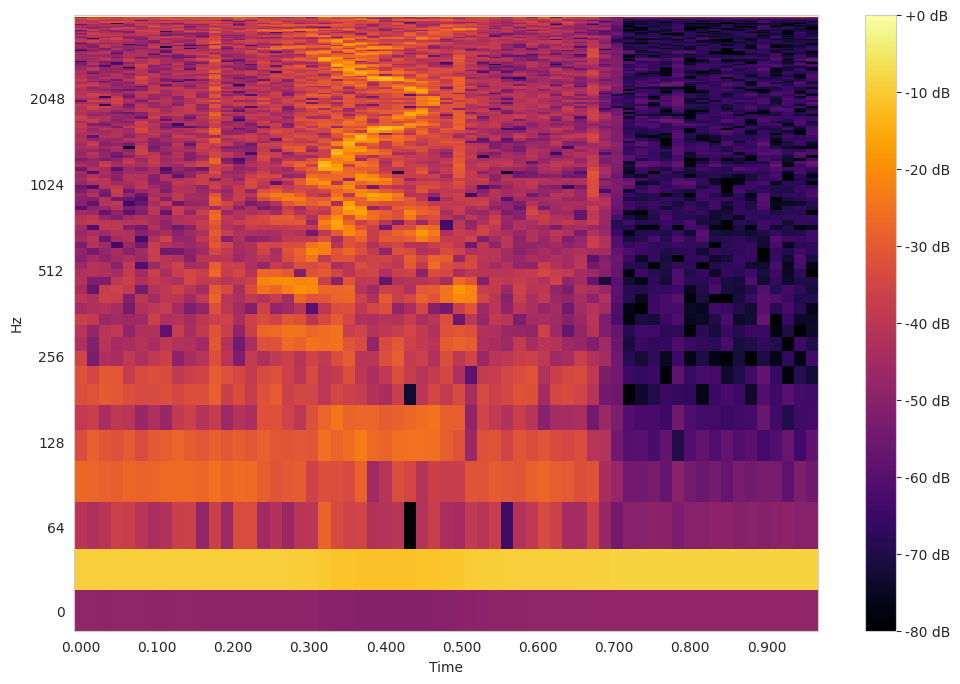

In [126]:
S_db = librosa.amplitude_to_db(stft_data.reshape(129, 61, order='F'), ref = np.max)
# Plot the spectrogram
plt.figure(figsize=(12, 8))
librosa.display.specshow(S_db, x_axis='time', y_axis='log', sr=8e3, cmap='inferno',
                         hop_length=128)
plt.colorbar(format='%+2.0f dB')
plt.show()

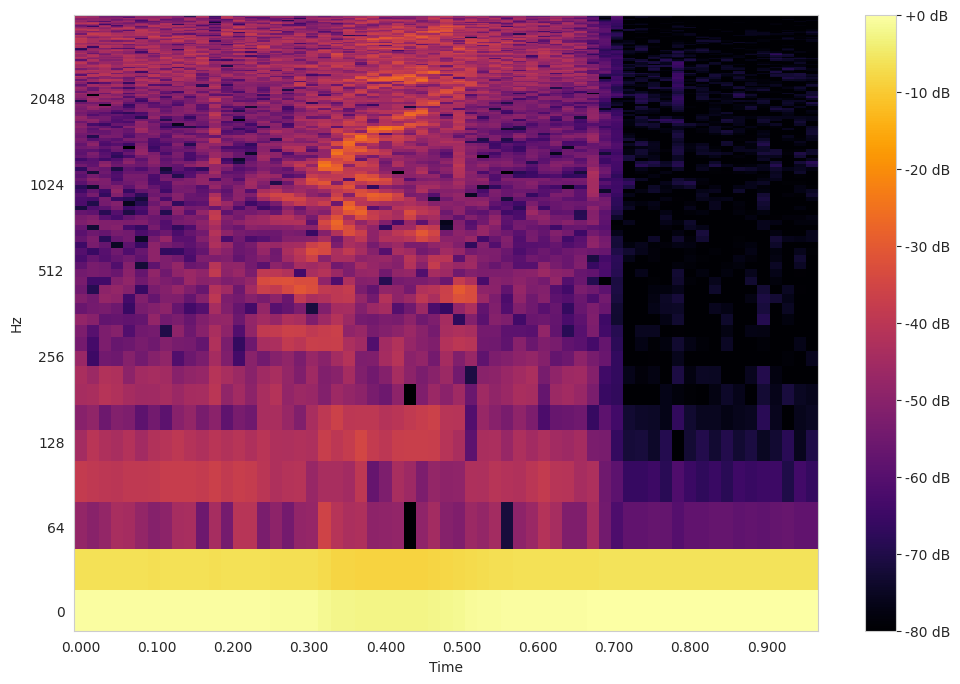

In [119]:
S_db = librosa.amplitude_to_db(microphone_data_sample, ref = np.max)
# Plot the spectrogram
plt.figure(figsize=(12, 8))
librosa.display.specshow(S_db, x_axis='time', y_axis='log', sr=8e3, cmap='inferno',
                         hop_length=128)
plt.colorbar(format='%+2.0f dB')
plt.show()

In [88]:
# stft_data = stft_data.reshape(129, 61, 1)
# stft_data = tf.image.resize(stft_data, [32, 32])
stft_data = downsample_image_fixed(stft_data, 129, 61, 32, 32).reshape(32, 32, 1)

In [89]:
stft_data.shape

(32, 32, 1)

In [45]:
stft_data /= 32768.0

In [46]:
np.max(stft_data)

0.44900778

In [70]:
microphone_data_sample = np.abs(stft(audio_data, fs=8e3, N=256, hop_size=128)[0])

In [71]:
microphone_data_sample.shape

(129, 61)

In [73]:
microphone_data_sample = downsample_image_fixed(microphone_data_sample.reshape(129*61), 129, 61, 32, 32).reshape(32, 32, 1)
microphone_data_sample.shape

(32, 32, 1)

In [76]:
np.max(microphone_data_sample)

17221.293

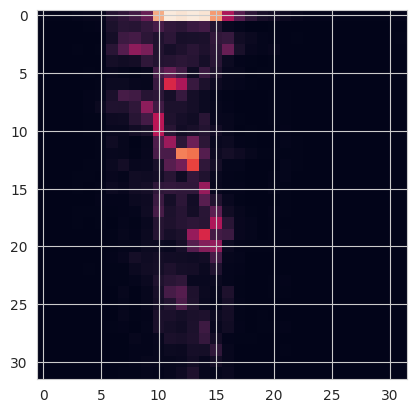

In [90]:
plt.imshow(microphone_data_sample.reshape(32, 32))

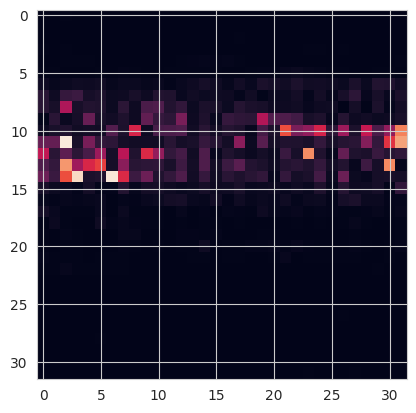

In [92]:
plt.imshow(stft_data.reshape(32, 32))

In [82]:
S_db = librosa.amplitude_to_db(n), ref=np.max)
# Plot the spectrogram
plt.figure(figsize=(12, 8))
librosa.display.specshow(S_db, x_axis='time', y_axis='log', sr=8e3, cmap='inferno', hop_length=128)
plt.colorbar(format='%+2.0f dB')
plt.show()

In [80]:
#sample_int8 = np.clip((stft_data / max_float_value / input_scale) + input_zero_point, -128, 127).astype(np.int8)
    
# Przekazanie danych do interpretera
interpreter.set_tensor(input_details[0]['index'], tf.expand_dims(stft_data, 0))
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])[0]

# Odkwantyzacja wyjścia
#output_data_float = (output_data - input_zero_point) * input_scale

# Klasyfikacja (argmax)
predicted_class = np.argmax(output_data)

In [81]:
prediction_dict.get(predicted_class)

'stop'